In [13]:
import numpy as np
from copy import deepcopy
from pprint import pprint
import sys, os

sys.path.append('utils/')
from modeling_analysis_utils import plot_example_traces, load_neurons, load_baier_regions, LRsplit, build_traces, load_baier_connectome, build_neural_S, oasis_decon

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


7121


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


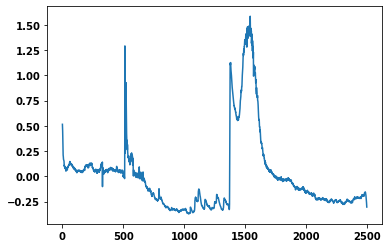

In [2]:
## Load traces from major brain regions

FISH_ID = 2
traces_full_filepath         = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID
mask_filepath                = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID

###

all_spatial_ids, all_spatial_coords  = load_neurons(mask_filepath, region_name=['Telencephalon -', 
                                                                         'Mesencephalon -', 
                                                                         'Diencephalon -', 
                                                                         'Rhombencephalon -',], extend=True)

print(len(all_spatial_ids))

unique_ids = []
unique_coord_idxs = []
for (idx,i) in enumerate(range(len(all_spatial_ids))):
    current_id = all_spatial_ids[i]
    if current_id not in unique_ids:
        unique_ids.append(current_id)
        unique_coord_idxs.append(idx)

all_spatial_coords = np.asarray(all_spatial_coords, dtype='float32')[unique_coord_idxs,:]
all_spatial_ids    = np.asarray(unique_ids, dtype='uint32')

ftraces = np.load(traces_full_filepath)
traces  = ftraces['tracez']
roi_traces     = traces[all_spatial_ids,:].astype('float32')
spatial_coords = all_spatial_coords.astype('float32')

plt.figure()
plt.plot(np.mean(roi_traces,axis=0))


343 6701


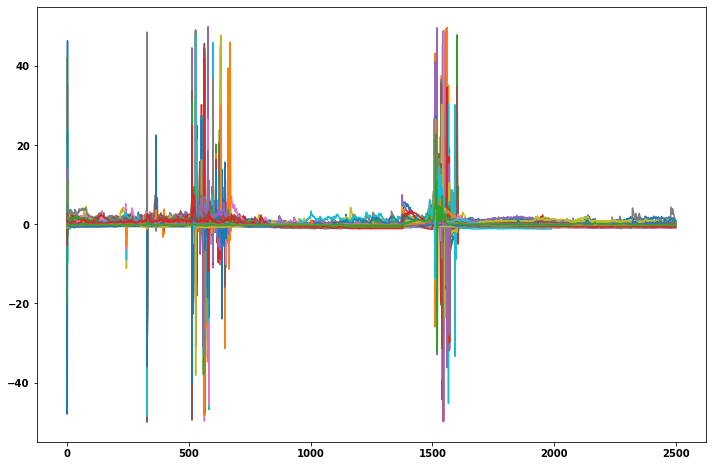

In [3]:
# find peak

def iron_bumps(traces, tb=20, db=20):
    traces = deepcopy(traces)
    idxs = []
    N, T = traces.shape
    for i in range(N):
        trace = traces[i,:]
        diff = np.diff(trace,1)
        
        trace_bad = np.where(abs(trace) > tb)[0]
        diff_bad  = np.where(abs(diff) > db)[0]
        if len(trace_bad) > 0 or len(diff_bad) > 0:
            idxs.append(i)
    return idxs

bad_idxs = iron_bumps(roi_traces, tb=25, db=25)
good_idxs = list(set(range(roi_traces.shape[0])) - set(bad_idxs))
print(len(bad_idxs), len(good_idxs))

valid_roi_traces     = roi_traces[good_idxs,:]
valid_spatial_coords = spatial_coords[good_idxs,:]
                        
####
                                    
plt.figure(figsize=(12,8))
plt.plot(roi_traces[bad_idxs,:].T)
plt.show()


In [80]:
f = np.savez('../data/fish-%i-processed.npz' % FISH_ID, coords=valid_spatial_coords,traces=valid_roi_traces, 
             idxs=all_spatial_ids, good_idxs=good_idxs, bad_idxs=bad_idxs)

In [ ]:
# figures needed for ms fig 1

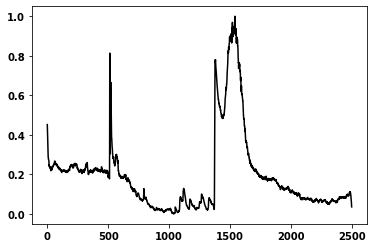

In [60]:
plt.figure()
mt = np.mean(valid_roi_traces,axis=0)
mt -= np.min(mt)
mt /= np.max(mt)
plt.plot(mt, color='k')
plt.savefig('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/figs/f1/traces/mean-trace.svg')

In [4]:
def get_regional_data(region_name):
    spat_ids, spat_coords = load_neurons(mask_filepath, region_name=region_name)
    region_traces = traces[spat_ids,:]

    bad_idxs = iron_bumps(region_traces, tb=25, db=25)
    good_idxs = list(set(range(region_traces.shape[0])) - set(bad_idxs))
    region_traces = region_traces[good_idxs,:]
    region_scoords = spat_coords[good_idxs,:]
    
    return region_traces, region_scoords

telen_traces, telen_scoords = get_regional_data('Telencephalon -')
mesen_traces, mesen_scoords = get_regional_data('Mesencephalon -')
dien_traces, dien_scoords = get_regional_data('Diencephalon -')
rhomb_traces, rhomb_scoords = get_regional_data('Rhombencephalon -')



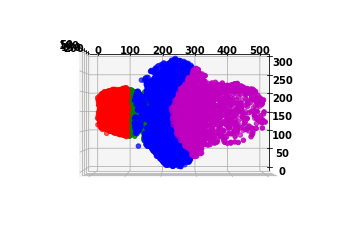

In [85]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*mesen_scoords.T, color='b')
ax.scatter(*dien_scoords.T, color='g')
ax.scatter(*rhomb_scoords.T, color='m')
ax.scatter(*telen_scoords.T, color='r')
ax.view_init(-90,0)

plt.savefig('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/figs/f1/rois-flip.svg')

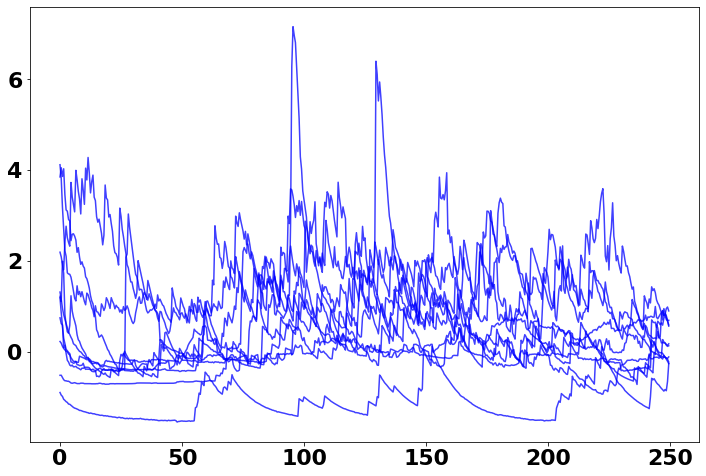

In [22]:
#pickten = np.random.randint(0, len(telen_traces), size=(10,))
plt.figure(figsize=(12,8))
plt.plot(np.arange(telen_traces.shape[1])[:500]/2., telen_traces[pickten,0:500].T, color='b', alpha=0.75)
plt.savefig('traces.svg')


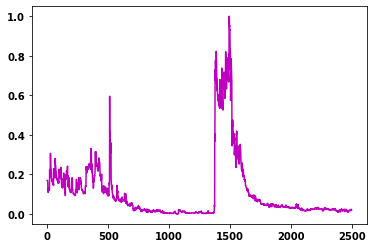

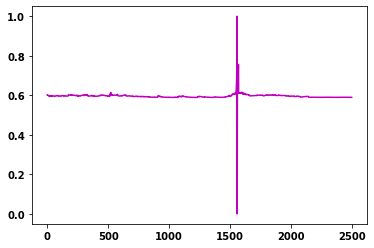

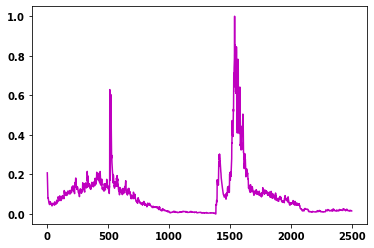

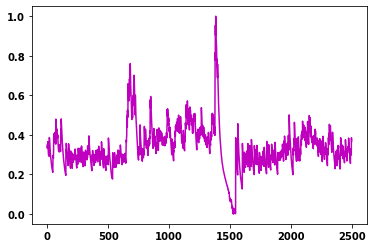

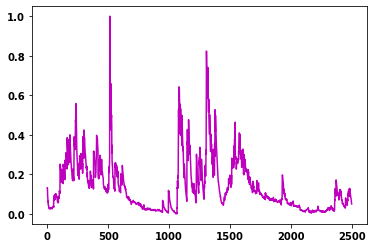

In [70]:
for i in range(0,5):
    idx = np.random.randint(0,telen_traces.shape[0])
    t = telen_traces[idx,:]
    t -= np.min(t)
    t /= np.max(t)
    plt.figure()
    plt.plot(t, c='m')
    plt.savefig('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/figs/f1/traces/rhomb-traces-f2-%d.svg' % idx)

In [109]:
temporal_xcorr = np.corrcoef(valid_roi_traces.T)
temporal_xcorr = np.clip(temporal_xcorr, 0., 1.)
membership = np.zeros(temporal_xcorr.shape[0], dtype='uint8')
membership[0:500] = 0
membership[500:1270] = 1
membership[1270:1470] = 2
membership[1470:] = 3

from graph_utils import generate_igraph
g, weights = generate_igraph(temporal_xcorr, directed=False)
modularity = g.modularity(membership, weights=weights)

print('temporal modularity: %0.3f' % modularity)

temporal modularity: 0.529


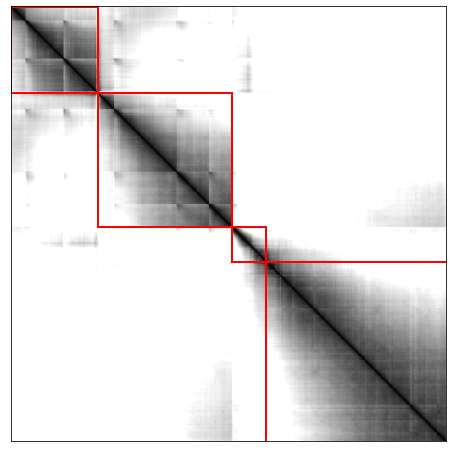

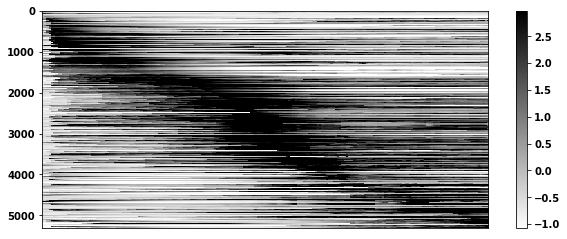

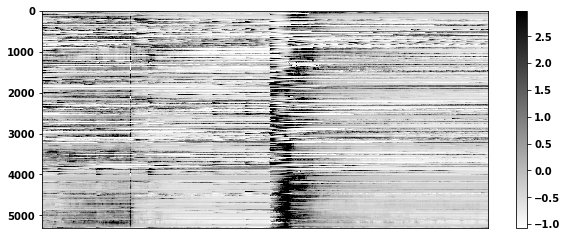

In [178]:
import matplotlib.patches as patches


control_rect = patches.Rectangle((0, 0), 500, 500, linewidth=2, edgecolor='r', facecolor='none')
presz_rect   = patches.Rectangle((500,500),770,770, linewidth=2, edgecolor='r', facecolor='none')
sz_rect      = patches.Rectangle((1270,1270),200,200, linewidth=2, edgecolor='r', facecolor='none')
postsz_rect  = patches.Rectangle((1470,1470),traces.shape[1]-200,traces.shape[1]-200, linewidth=2, edgecolor='r', facecolor='none')


fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(np.corrcoef(valid_roi_traces.T), vmin=0., vmax=1., cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])

ax.add_patch(control_rect)
ax.add_patch(presz_rect)
ax.add_patch(sz_rect)
ax.add_patch(postsz_rect)

c2 = np.percentile(valid_roi_traces, 2.)
c98 = np.percentile(valid_roi_traces,98.)

plt.figure(figsize=(10,4))
targmax = [np.argmax(valid_roi_traces[n,1270:1470]) for n in range(valid_roi_traces.shape[0])]
tsorted = np.argsort(targmax)
plt.imshow(valid_roi_traces[tsorted,1270:1470], cmap='gray_r', vmin=c2, vmax=c98, aspect='auto')
plt.xticks([])
plt.colorbar()

plt.figure(figsize=(10,4))
plt.imshow(valid_roi_traces[:,:], cmap='gray_r', vmin=c2, vmax=c98, aspect='auto')
plt.xticks([])
plt.colorbar()



In [162]:
telen_ids, _  = load_neurons(mask_filepath, region_name='Telencephalon -')
mesen_ids, _  = load_neurons(mask_filepath, region_name='Mesencephalon -')
dien_ids, _  = load_neurons(mask_filepath, region_name='Diencephalon -')
rhomb_ids, _  = load_neurons(mask_filepath, region_name='Rhombencephalon -')
ltele = len(telen_ids)
lmesen = len(mesen_ids)
ldien = len(dien_ids)
lrhomb = len(rhomb_ids)
print(ltele, lmesen, ldien, lrhomb)

tcount, mcount, dcount, rcount = 0, 0, 0, 0
for t in tsorted[0:1000]:
    tt = good_idxs[t]
    if tt in range(0, ltele):
        tcount += 1
    elif tt in range(ltele, ltele+lmesen):
        mcount += 1
    elif tt in range(ltele+lmesen, ltele+lmesen+ldien):
        dcount += 1
    elif tt in range(ltele+lmesen+ldien, ltele+lmesen+ldien+lrhomb):
        rcount += 1
        
print(tcount/float(ltele), mcount/float(lmesen), dcount/float(ldien), rcount/float(lrhomb))

1040 2350 1987 1744
0.20192307692307693 0.1646808510638298 0.101157523905385 0.1158256880733945
